## Notebook for applying Data Assimilation on seasonal SST data (PWP reconstructions)

### Assembling data in the proxy domain

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam

# Load packages

In [1]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR
## Load monthly model data

In [2]:
# Load model data as prior and show data structure
PlioMIP = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


### Convert model data to D47 domain using the regression by Daëron and Vermeesch (2023)

In [3]:
# Apply T47()-function from the D47calib package to all columns except 'modelname'
PlioMIP_D47 = PlioMIP.copy() # Create dataframe to store D47 values
PlioMIP_D47_SE = PlioMIP.copy() # Create dataframe to store D47 uncertainties due to the calibration
PlioMIP_D47.iloc[:, 1:] = PlioMIP_D47.iloc[:, 1:].apply(lambda col: col.map(lambda x: D47c.OGLS23.T47(T = x)[0])) # Apply T47()-function to convert all model temperatures to D47 values
PlioMIP_D47_SE.iloc[:, 1:] = PlioMIP_D47_SE.iloc[:, 1:].apply(lambda col: col.map(lambda x: D47c.OGLS23.T47(T = x)[1])) # Trace calibration uncertainty on D47 values

print("D47 values for all model outcomes:\n", PlioMIP_D47.head())
print("Calibration standard errors for all model outcomes:\n", PlioMIP_D47_SE.head())

D47 values for all model outcomes:
      modelname        ja        fb        mr        ar        my        jn  \
0    CCSM4-UoT  0.648316  0.652623  0.651496  0.643531  0.630811  0.613992   
1    CCSM4-Utr  0.642505  0.646808  0.646093  0.638746  0.626446  0.610876   
2       COSMOS  0.649830  0.654303  0.655404  0.651895  0.644028  0.634582   
3  EC-Earth3.3  0.645273  0.650879  0.651641  0.644774  0.629960  0.611356   
4     GISS2.1G  0.660998  0.665851  0.664716  0.654047  0.638118  0.623302   

         jl        ag        sp        ot        nv        dc  
0  0.601033  0.595364  0.600724  0.612897  0.625741  0.639340  
1  0.597955  0.592525  0.596581  0.606465  0.620618  0.633721  
2  0.625338  0.622040  0.625372  0.630777  0.637143  0.643850  
3  0.596246  0.592585  0.597772  0.608045  0.621676  0.634927  
4  0.613090  0.610812  0.616326  0.626950  0.640497  0.652477  
Calibration standard errors for all model outcomes:
      modelname        ja        fb        mr        ar    

## Seasonal model data

In [4]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
PlioMIP_seasonal = {}
PlioMIP_seasonal_SE = {}
for season, months in seasons.items():
    PlioMIP_seasonal[season] = pd.concat([PlioMIP_D47[month] for month in months], ignore_index = True)
    PlioMIP_seasonal_SE[season] = pd.concat([PlioMIP_D47_SE[month] for month in months], ignore_index = True)

# Add model names
PlioMIP_seasonal["modelname"] = np.tile(PlioMIP["modelname"], len(seasons["winter"]))
PlioMIP_seasonal_SE["modelname"] = np.tile(PlioMIP["modelname"], len(seasons["winter"]))

# Convert the seasonal data into a DataFrame
PlioMIP_seasonal = pd.DataFrame(PlioMIP_seasonal)
PlioMIP_seasonal_SE = pd.DataFrame(PlioMIP_seasonal_SE)

# Display the new seasonal DataFrame
print("D47 values for all model outcomes:\n", PlioMIP_seasonal)
print("Calibration standard errors for all model outcomes:\n", PlioMIP_seasonal_SE)

D47 values for all model outcomes:
       winter    spring    summer    autumn    modelname
0   0.639340  0.651496  0.613992  0.600724    CCSM4-UoT
1   0.633721  0.646093  0.610876  0.596581    CCSM4-Utr
2   0.643850  0.655404  0.634582  0.625372       COSMOS
3   0.634927  0.651641  0.611356  0.597772  EC-Earth3.3
4   0.652477  0.664716  0.623302  0.616326     GISS2.1G
5   0.640708  0.647274  0.614477  0.599675       HadCM3
6   0.626984  0.643319  0.616880  0.601095      HadGEM3
7   0.637561  0.648064  0.614930  0.606623     IPSLCM6A
8   0.641517  0.649396  0.611068  0.610461      MIROC4m
9   0.643142  0.645273  0.629892  0.626210       MRI2.3
10  0.636935  0.646701  0.610110  0.605082    NorESM1-F
11  0.648316  0.643531  0.601033  0.612897    CCSM4-UoT
12  0.642505  0.638746  0.597955  0.606465    CCSM4-Utr
13  0.649830  0.651895  0.625338  0.630777       COSMOS
14  0.645273  0.644774  0.596246  0.608045  EC-Earth3.3
15  0.660998  0.654047  0.613090  0.626950     GISS2.1G
16  0.645487

## Monthly prior

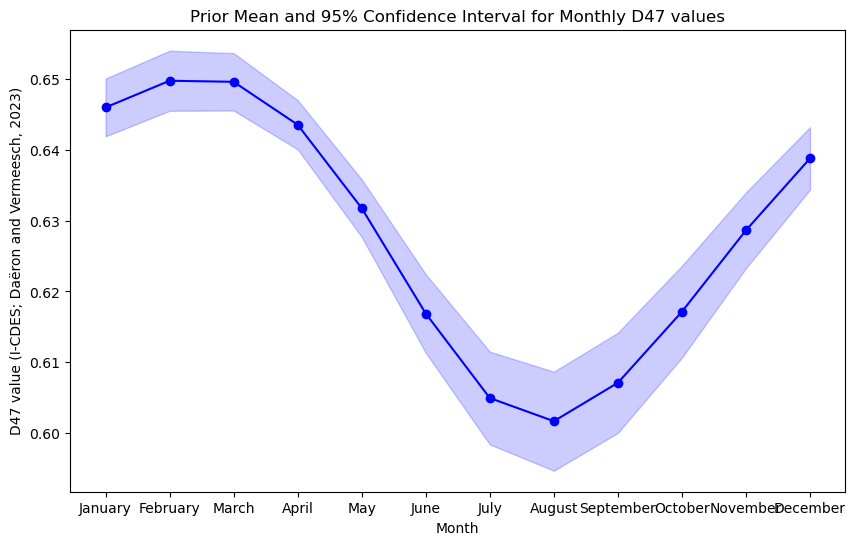

In [5]:
# Establish and plot prior distribution of D47 values based on PlioMIP model outcomes
# Propagate uncertainties on D47 values that result from the calibration

# Set dimensions of data
n_months = len(PlioMIP_D47.iloc[1,:]) - 1
n_models = len(PlioMIP_D47["ja"])

# Set the weights of the data based on the standard errors
weights = 1 / PlioMIP_D47_SE.iloc[:, 1:] ** 2

# Prior D47 estimates from climate models (weighted mean)
mu_prior = (PlioMIP_D47.iloc[:, 1:] * weights).sum(axis = 0) / weights.sum(axis = 0) # Calculate weighted monthly mean D47 values

# Decompose variance within and between model outcomes
model_variances = PlioMIP_D47.iloc[:, 1:].var(axis = 0, ddof = 1) # Compute variance across models
measurement_variances = (PlioMIP_D47_SE.iloc[:, 1:] ** 2).mean(axis = 0) # Compute variance on measurements

# Prior D47 estimates from climate models (weighted covariance matrix)
cov_raw = np.cov(PlioMIP_D47.iloc[:, 1:], rowvar = False) # Compute the covariance matrix for the data (without measurement uncertainty)
cov_prior = cov_raw.copy() # Copy covariance matrix to add uncertainty coming from the measurements 
np.fill_diagonal(cov_prior, np.diagonal(cov_raw) + measurement_variances) # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means
mu_prior_original, cov_prior_original = mu_prior.copy(), cov_prior.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior = np.sqrt(np.diag(cov_prior))

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months = np.arange(1, n_months + 1) # Create monthly scale
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize = (10, 6))
plt.plot(months, mu_prior, label = 'Prior Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Monthly D47 values')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± t_inv * standard deviation)
plt.fill_between(months,
    mu_prior - stats.t.ppf(1 - 0.025, n_models) * std_prior / np.sqrt(n_models),
    mu_prior + stats.t.ppf(1 - 0.025, n_models) * std_prior / np.sqrt(n_models), 
    color='b',
    alpha = 0.2,
    label='95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(months, month_names)
plt.show() # Show plot

## Seasonal prior

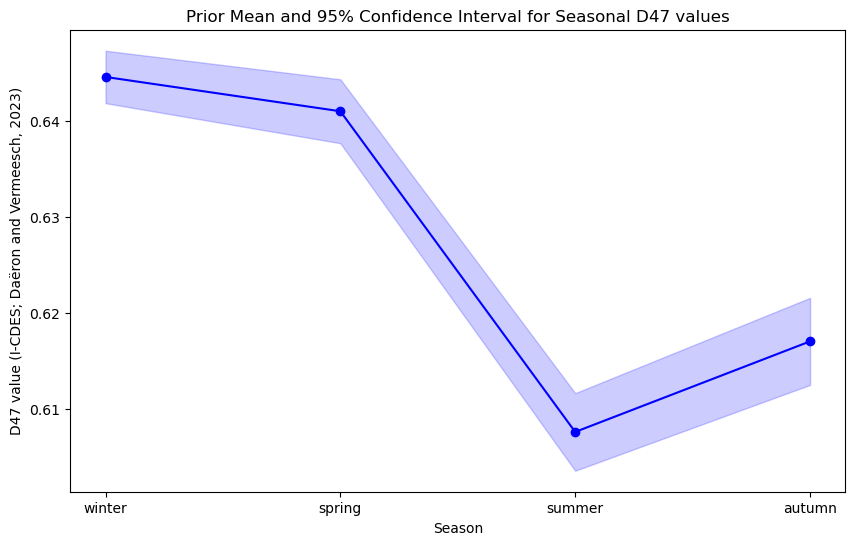

In [6]:
# Establish and plot prior distribution based on seasonal PlioMIP model outcomes

# Set dimensions of data
n_seasons_scale = len(PlioMIP_seasonal.iloc[1,:]) - 1
n_models_seasonal = len(PlioMIP_seasonal["summer"])
season_names = seasons.keys()

# Set the weights of the data based on the standard errors
weights_seasonal = 1 / PlioMIP_seasonal_SE.iloc[:, :n_seasons_scale] ** 2

# Prior D47 estimates from climate models (weighted mean and covariance of season)
mu_prior_seasonal = (PlioMIP_seasonal.iloc[:, :n_seasons_scale] * weights_seasonal).sum(axis = 0) / weights_seasonal.sum(axis = 0) # Calculate weighted monthly mean D47 values

# Decompose variance within and between model outcomes
model_variances = PlioMIP_seasonal.iloc[:, :n_seasons_scale].var(axis = 0, ddof = 1) # Compute variance across models
measurement_variances = (PlioMIP_seasonal_SE.iloc[:, :n_seasons_scale] ** 2).mean(axis = 0) # Compute variance on measurements

# Prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal = np.cov(PlioMIP_seasonal.iloc[:, :n_seasons_scale], rowvar = False) # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_seasonal = cov_raw_seasonal.copy() # Copy covariance matrix to add uncertainty coming from the measurements 
np.fill_diagonal(cov_prior_seasonal, np.diagonal(cov_raw_seasonal) + measurement_variances) # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means
mu_prior_seasonal_original, cov_prior_seasonal_original = mu_prior_seasonal.copy(), cov_prior_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_seasonal = np.sqrt(np.diag(cov_prior_seasonal))

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(1, n_seasons_scale + 1) # Create seasonal scale

plt.figure(figsize = (10, 6))
plt.plot(seasons_scale, mu_prior_seasonal, label = 'Prior Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Seasonal D47 values')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(seasons_scale, season_names)
plt.show() # Show plot

# UPDATE
## Load clumped data for updating
### in this version "online" updating is applied, adding datapoints to the posterior one by one.
### Seasonal data from PWP paper

In [7]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
PWP_D47_seasonal = pd.read_csv('PWP case/PWP_proxy_data_seasonal.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_seasonal_dict = PWP_D47_seasonal.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated seasonally)
for record in PWP_D47_seasonal_dict:
    record["Season_err"] = 0

# print(PWP_D47_seasonal_dict[0]) # Print to check the structure of the data

### Monthly and seasonal data calculated from ShellChron outcomes

In [8]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data_months.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys

# Process the ShellChron_DOY_err field and create a new entry for months
for record in PWP_D47_dict:
    # Handle missing values and convert from days to months and seasons
    shell_chron_doy_err = record.get("ShellChron_DOY_err", np.nan)  # Get value, default to NaN if missing
    if pd.isna(shell_chron_doy_err):  # Check if the value is NaN
        record["ShellChron_Month_err"] = 0  # Set the new entry to 0 if missing
        record["ShellChron_Season_err"] = 0  # Set the new entry to 0 if missing
    else:
        record["ShellChron_Month_err"] = shell_chron_doy_err / 365 * 12  # Convert days to months
        record["ShellChron_Season_err"] = shell_chron_doy_err / 365 * 4  # Convert days to seasons
    
    # Add the month_score2 and season_score field based on the ShellChron_DOY field
    ShellChron_DOY = record.get("ShellChron_DOY_rotated", np.nan)  # Get the ShellChron day of the year value
    if not pd.isna(ShellChron_DOY):  # Check if the ShellChron value is not NaN
        record["month_score2"] = ShellChron_DOY / 365 * 12  # Convert DOY value to month_score
        record["season_score"] = ShellChron_DOY / 365 * 4  # Convert DOY value to season_score

# print(PWP_D47_dict[0]) # Print to check the structure of the data

## Create updating function (Kalman filter)

In [9]:
# Create Kalman updating function
def kalman_update(
    mu_prior,
    cov_prior,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "T_mean",
    Variable_name_SD = "T_sd",
):
    """
Update the prior state with a measurement, including uncertainty in the time domain.

Parameters:
- mu_prior: np.ndarray
    Prior means for all bins.
- cov_prior: np.ndarray
    Covariance matrix for the prior state.
- measurement: dict
    Dictionary containing the observation, its SD, and a timestamp value with its SD.
- timestamp: str
    Key in the measurement dictionary for the timestamp (0-based index).
- timestamp_sd: float
    Standard deviation of uncertainty in the timestamp (in units of timestamp).
- Variable_name: str
    Key in the measurement dictionary for the data.
- Variable_name_SD: str
    Key in the measurement dictionary for the standard deviation on the data.

Returns:
- mu_prior: np.ndarray
    Updated means after applying the measurement.
- cov_prior: np.ndarray
    Updated covariance matrix after applying the measurement.
"""
    try: # Catch errors in individual entries without breaking the loop
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        obs_variable = measurement[Variable_name]
        obs_var = measurement[Variable_name_SD] ** 2

        if not np.isnan(time) and not np.isnan(obs_variable) and not np.isnan(obs_var):
            # If there is no uncertainty in the timestamp
            if time_sd == 0 or np.isnan(time_sd):
                # Direct update without using weights (standard Kalman update)

                # Prior mean and variance for the specific time
                mu_prior_time = mu_prior[int(time)]
                cov_prior_time = cov_prior[int(time), int(time)]
                
                # Kalman gain
                K = cov_prior_time / (cov_prior_time + obs_var)

                # Update mean and variance
                mu_post_time = mu_prior_time + K * (obs_variable - mu_prior_time)
                cov_post_time = (1 - K) * cov_prior_time
                
                # Update the prior arrays with the new posterior values to create posteriors
                mu_post = mu_prior.copy()
                cov_post = cov_prior.copy()
                mu_post[int(time)] = mu_post_time
                cov_post[int(time), int(time)] = cov_post_time
            else:
                # Define possible bins and weights based on normal uncertainty on the age of the measurement
                n_bins = len(mu_prior)
                month_indices = np.arange(n_bins)
                weights = stats.norm.pdf(month_indices, loc = time, scale = time_sd)
                weights = weights / weights.sum()  # Normalize weights

                # Weighted observation and variance
                weighted_obs = np.sum(weights * mu_prior) # calculate the weighted prior mean
                weighted_var = obs_var + np.sum(weights ** 2 * np.diag(cov_prior)) # calculate a weighted variance with respect to the uncertainty distribution of the time of the measurement

                # Kalman gain weighted by the uncertainty on the age determination
                K = np.dot(cov_prior, weights) / (np.dot(weights, np.dot(cov_prior, weights)) + weighted_var)

                # Update mean values
                mu_post = mu_prior + K * (obs_variable - weighted_obs)

                ## FIXME: Sometimes results in negative variance, which is not possible!!
                ## Potential solution: Overwrite diagonal elements with the weighted variances?
                ## Other potential solution: Check if problem occurs without weights (i.e., time_sd = 0)

                # Update covariance matrix using Joseph form to ensure positive semi-definite matrix
                I = np.eye(n_bins) # Identity matrix
                KH = np.outer(K, weights) # Product of Kalman gain and weights
                cov_post = np.dot(np.dot((I - KH), cov_prior), (I - KH).T) + np.outer(K, K) * weighted_var
                
                # cov_post = cov_prior - np.outer(K, np.dot(weights, cov_prior)) # Simplified form without Joseph form

            # Return updated values
            return mu_post, cov_post
        
        return mu_prior, cov_prior  # If observation is NaN, return unmodified values

    except (KeyError, TypeError, ValueError) as e: # Return errors if they occur
        print(f"Error in kalman_update: {e}")
        return mu_prior, cov_prior  # Return the unmodified values even on error to prevent errors during the looping later

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [10]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

## EXECUTE UPDATING FUNCTIONS

## Update seasonal prior with data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

In [11]:
# Update the seasonal prior with all measurements
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    # This aggregates the data to update the prior to the posterior
    mu_prior_seasonal, cov_prior_seasonal = kalman_update(
        mu_prior_seasonal,
        cov_prior_seasonal,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_sd"
    )
    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_sd"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

Likelihood statistics:
Month: 1
Weighted Average D47: 0.6556636868044415
Aggregated Uncertainty (D47_sd): 0.004260844079332398
Number of Data Points: 4.0

Month: 2
Weighted Average D47: 0.6486227681197775
Aggregated Uncertainty (D47_sd): 0.006543100902155715
Number of Data Points: 7.0

Month: 3
Weighted Average D47: 0.6200978033855928
Aggregated Uncertainty (D47_sd): 0.0050737212353118375
Number of Data Points: 7.0

Month: 4
Weighted Average D47: 0.638399979837096
Aggregated Uncertainty (D47_sd): 0.005301007014880267
Number of Data Points: 7.0



### Plot seasonal posterior in D47 domain

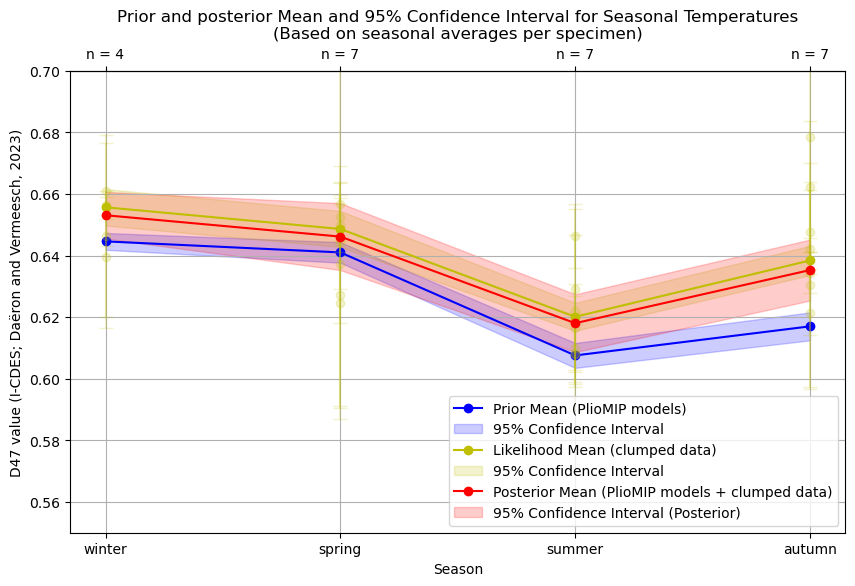

In [12]:
# Plot the updated seasonal posterior
std_post_seasonal = np.sqrt(np.diag(cov_prior_seasonal))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, measurement["D47"], yerr = measurement["D47_sd"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    mu_prior_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datrapoint as an individual datapoint

In [ ]:
# FIXME: Results in negative variance for winter, which is not possible!! (and does not occur in the SAT cross-covariance example)
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC = mu_prior_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_seasonalSC, cov_prior_seasonalSC = mu_prior_seasonal_original.copy(), cov_prior_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # print(measurement["season_score"])
    # This aggregates the data to update the prior to the posterior
    mu_prior_seasonalSC, cov_prior_seasonalSC = kalman_update(
        mu_prior_seasonalSC,
        cov_prior_seasonalSC,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )
    # print(np.diag(cov_prior_seasonalSC))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC, effective_weights_total_seasonalSC, n_update_seasonalSC, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC,
        effective_weights_total_seasonalSC,
        n_update_seasonalSC,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC)):
    if effective_weights_total_seasonalSC[i] is not None and effective_weights_total_seasonalSC[i] != 0:
        mu_likelihood_seasonalSC[i] = weighted_sum_seasonalSC[i] / effective_weights_total_seasonalSC[i]
        std_likelihood_seasonalSC[i] = np.sqrt(1 / effective_weights_total_seasonalSC[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC[i]}\n")

Likelihood statistics:
Season: 1
Weighted Average D47: 0.6411885461843453
Aggregated Uncertainty (D47_sd): 0.004545033585204633
Number of Data Points: 138.0

Season: 2
Weighted Average D47: 0.6404147619988151
Aggregated Uncertainty (D47_sd): 0.0030196112784751836
Number of Data Points: 163.0

Season: 3
Weighted Average D47: 0.633664596817049
Aggregated Uncertainty (D47_sd): 0.0040579816663795665
Number of Data Points: 92.0

Season: 4
Weighted Average D47: 0.6381644715017567
Aggregated Uncertainty (D47_sd): 0.0029549715803734145
Number of Data Points: 156.0



### Plot seasonal posterior in D47 domain based on ShellChron dating

C:\Users\nwi213\AppData\Local\Temp\ipykernel_28728\4277756003.py:2: RuntimeWarning: invalid value encountered in sqrt
  std_post_seasonalSC = np.sqrt(np.diag(cov_prior_seasonalSC))


[[-7.36148619e-06  1.08705339e-05 -1.41499322e-05  1.33644081e-05]
 [ 1.08705339e-05  2.47686240e-06  9.70153258e-06 -6.37727088e-06]
 [-1.41499322e-05  9.70153258e-06  8.25702776e-06  5.56475476e-06]
 [ 1.33644081e-05 -6.37727088e-06  5.56475476e-06  4.78168767e-06]]
[[ 5.96544868e-05 -9.75939560e-06 -9.28799130e-06  7.21361522e-05]
 [-9.75939560e-06  8.86181632e-05  7.66347401e-05 -3.75297789e-05]
 [-9.28799130e-06  7.66347401e-05  1.30522038e-04  1.45477553e-05]
 [ 7.21361522e-05 -3.75297789e-05  1.45477553e-05  1.64404728e-04]]


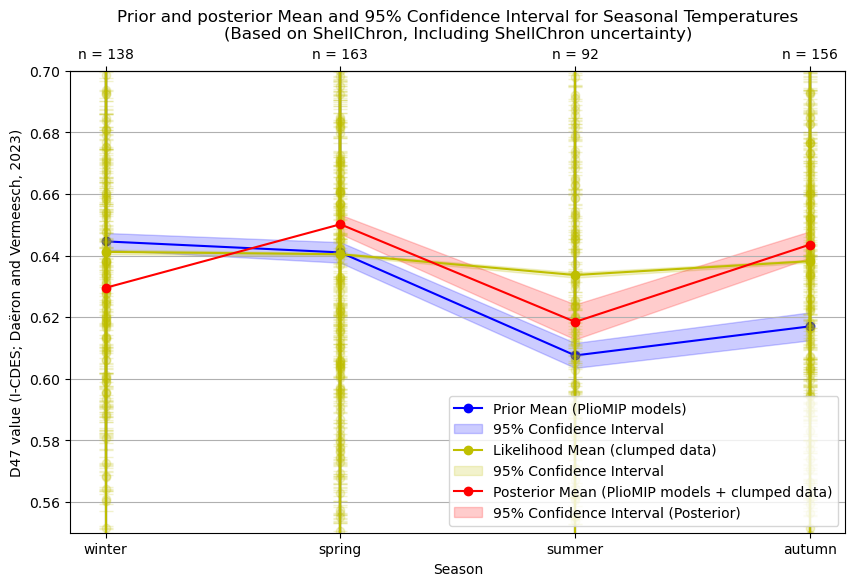

In [18]:
# Plot the updated seasonal posterior
std_post_seasonalSC = np.sqrt(np.diag(cov_prior_seasonalSC))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonalSC, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_seasonalSC,
    mu_prior_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_seasonalSC,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
print(cov_prior_seasonalSC)
print(cov_prior_seasonal_original)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [19]:
## Update seasonal prior with data based on ShellChron (without sclero-dating uncertainty)
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC_noerr = mu_prior_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_noerr = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_noerr = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_noerr = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_noerr = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_seasonalSC_noerr, cov_prior_seasonalSC_noerr = mu_prior_seasonal_original.copy(), cov_prior_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Season_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_seasonalSC_noerr, cov_prior_seasonalSC_noerr = kalman_update(
        mu_prior_seasonalSC_noerr,
        cov_prior_seasonalSC_noerr,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )
    # print(np.diag(cov_prior_seasonalSC_noerr))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_noerr, effective_weights_total_seasonalSC_noerr, n_update_seasonalSC_noerr, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC_noerr,
        effective_weights_total_seasonalSC_noerr,
        n_update_seasonalSC_noerr,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC_noerr)):
    if effective_weights_total_seasonalSC_noerr[i] is not None and effective_weights_total_seasonalSC_noerr[i] != 0:
        mu_likelihood_seasonalSC_noerr[i] = weighted_sum_seasonalSC_noerr[i] / effective_weights_total_seasonalSC_noerr[i]
        std_likelihood_seasonalSC_noerr[i] = np.sqrt(1 / effective_weights_total_seasonalSC_noerr[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC_noerr[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC_noerr[i]}\n")

Likelihood statistics:
Season: 1
Weighted Average D47: 0.6431055625988262
Aggregated Uncertainty (D47_sd): 0.0034272398735723094
Number of Data Points: 138.0

Season: 2
Weighted Average D47: 0.6366952930943864
Aggregated Uncertainty (D47_sd): 0.0031873068469998713
Number of Data Points: 163.0

Season: 3
Weighted Average D47: 0.632544577069042
Aggregated Uncertainty (D47_sd): 0.004248672755485735
Number of Data Points: 92.0

Season: 4
Weighted Average D47: 0.639809324473966
Aggregated Uncertainty (D47_sd): 0.0032553725427988934
Number of Data Points: 156.0



### Plot seasonal posterior in D47 domain based on ShellChron dating

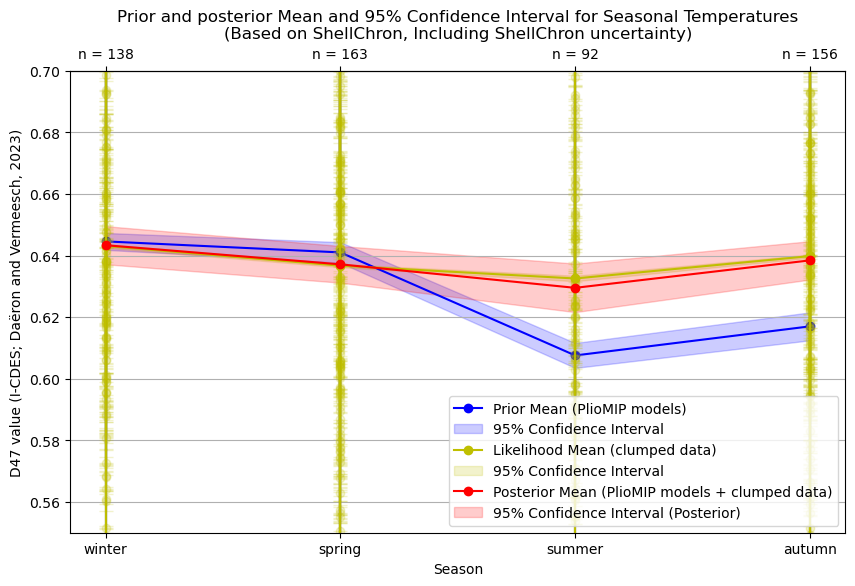

In [20]:
# Plot the updated seasonal posterior
std_post_seasonalSC_noerr = np.sqrt(np.diag(cov_prior_seasonalSC_noerr))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonalSC_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_seasonalSC_noerr,
    mu_prior_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_seasonalSC_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

for measurement in PWP_D47_dict: # Loop over measurements
    # print(measurement["month_score2"])
    # This aggregates the data to update the prior to the posterior
    mu_prior, cov_prior = kalman_update(
        mu_prior,
        cov_prior,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

Likelihood statistics:
Month: 1
Weighted Average D47: 0.6369265015627088
Aggregated Uncertainty (D47_sd): 0.007240277188793679
Number of Data Points: 41.0

Month: 2
Weighted Average D47: 0.64223081203265
Aggregated Uncertainty (D47_sd): 0.006528996713828611
Number of Data Points: 50.0

Month: 3
Weighted Average D47: 0.651116332047029
Aggregated Uncertainty (D47_sd): 0.006282393316561035
Number of Data Points: 47.0

Month: 4
Weighted Average D47: 0.6392398455927666
Aggregated Uncertainty (D47_sd): 0.004579556079934737
Number of Data Points: 77.0

Month: 5
Weighted Average D47: 0.6357954404899306
Aggregated Uncertainty (D47_sd): 0.005218863174240913
Number of Data Points: 46.0

Month: 6
Weighted Average D47: 0.6382040696755339
Aggregated Uncertainty (D47_sd): 0.006418613298330763
Number of Data Points: 40.0

Month: 7
Weighted Average D47: 0.6356629944328056
Aggregated Uncertainty (D47_sd): 0.006450914722869744
Number of Data Points: 51.0

Month: 8
Weighted Average D47: 0.6262381032788624

### Plot monthly posterior in D47 domain

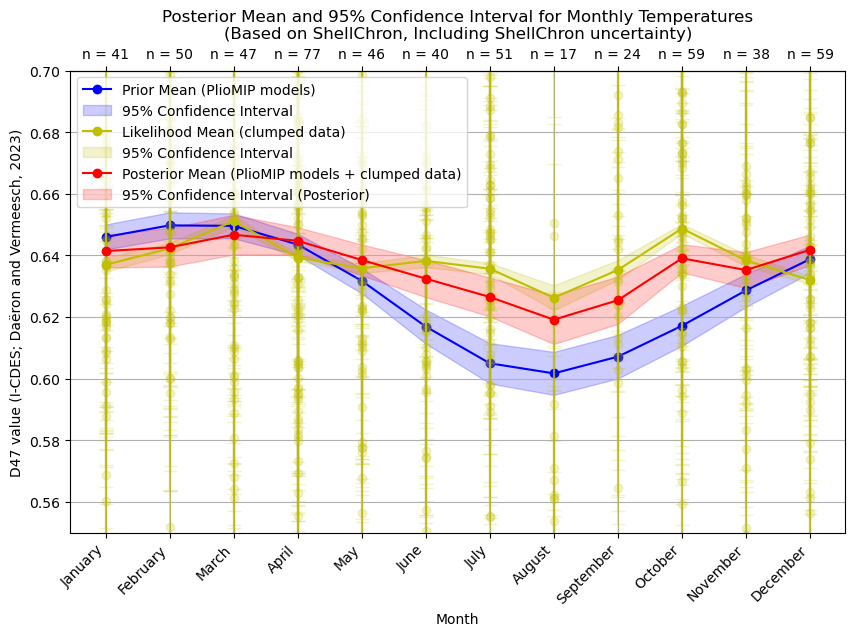

In [ ]:
# Plot the updated posterior
std_prior_original = np.sqrt(np.diag(cov_prior_original))
std_post = np.sqrt(np.diag(cov_prior))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_original - stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models),
    mu_prior_original + stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly),
    mu_likelihood_monthly + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_prior, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_post,
    mu_prior + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_post,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_noerr = mu_prior * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_noerr = mu_prior * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_noerr = mu_prior * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_noerr = mu_prior * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_noerr = mu_prior * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_noerr, cov_prior_noerr = mu_prior_original.copy(), cov_prior_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Month_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_noerr, cov_prior_noerr = kalman_update(
        mu_prior_noerr,
        cov_prior_noerr,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly_noerr, effective_weights_total_monthly_noerr, n_update_monthly_noerr, monthly_data = likelihood_statistics(
        weighted_sum_monthly_noerr,
        effective_weights_total_monthly_noerr,
        n_update_monthly_noerr,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_noerr)):
    if effective_weights_total_monthly_noerr[i] is not None and effective_weights_total_monthly_noerr[i] != 0:
        mu_likelihood_monthly_noerr[i] = weighted_sum_monthly_noerr[i] / effective_weights_total_monthly_noerr[i]
        std_likelihood_monthly_noerr[i] = np.sqrt(1 / effective_weights_total_monthly_noerr[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_noerr[i]}")
    print(f"Number of Data Points: {n_update_monthly_noerr[i]}\n")

Likelihood statistics:
Month: 1
Weighted Average D47: 0.6286965046662804
Aggregated Uncertainty (D47_sd): 0.006172172468534013
Number of Data Points: 41.0

Month: 2
Weighted Average D47: 0.6619659675289109
Aggregated Uncertainty (D47_sd): 0.005702205186276009
Number of Data Points: 50.0

Month: 3
Weighted Average D47: 0.6359313809752828
Aggregated Uncertainty (D47_sd): 0.005962213370555013
Number of Data Points: 47.0

Month: 4
Weighted Average D47: 0.635874055245299
Aggregated Uncertainty (D47_sd): 0.004533472087358248
Number of Data Points: 77.0

Month: 5
Weighted Average D47: 0.6385765019088617
Aggregated Uncertainty (D47_sd): 0.005970373422008295
Number of Data Points: 46.0

Month: 6
Weighted Average D47: 0.6361053169591214
Aggregated Uncertainty (D47_sd): 0.006784491839417968
Number of Data Points: 40.0

Month: 7
Weighted Average D47: 0.6405577455241105
Aggregated Uncertainty (D47_sd): 0.005527388083791424
Number of Data Points: 51.0

Month: 8
Weighted Average D47: 0.58409634891180

### Plot monthly posterior without sclero-dating uncertainty in D47 domain

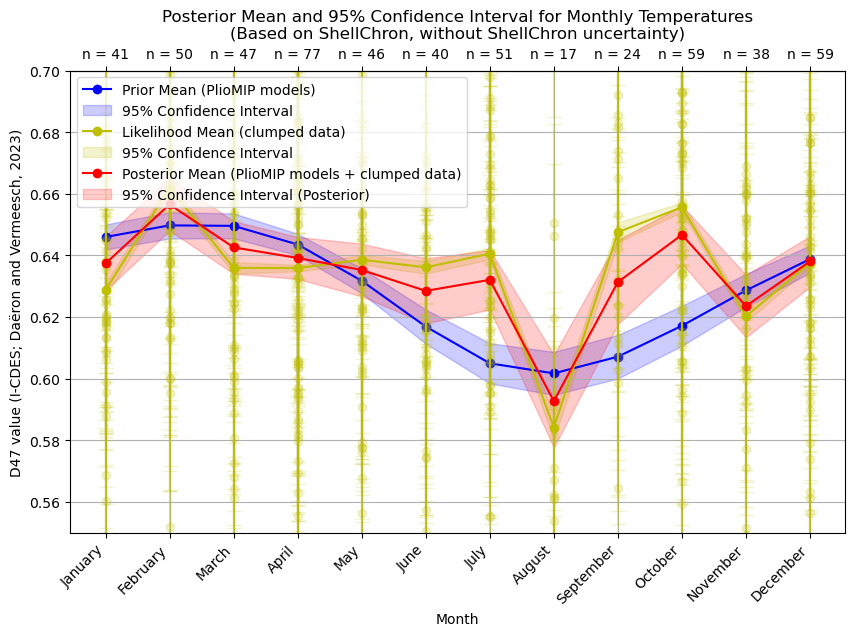

In [ ]:
# Plot the updated posterior
std_post_noerr = np.sqrt(np.diag(cov_prior_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_original - stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models),
    mu_prior_original + stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_noerr - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_prior_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_noerr - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_post_noerr,
    mu_prior_noerr + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_post_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# POSTERIORS IN SST DOMAIN

## Updated seasonal prior in SST domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Convert seasonal prior, likelihood and posterior to temperature and plot

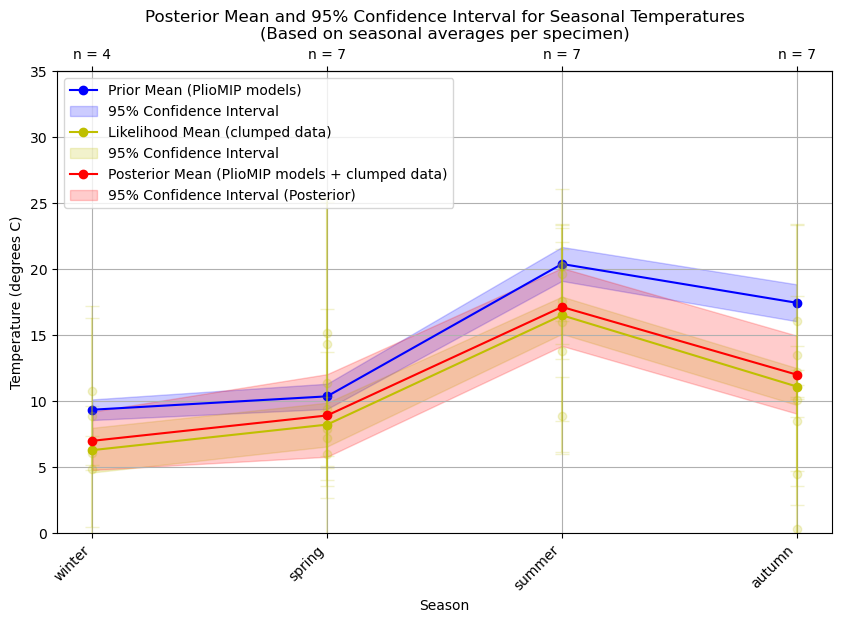

In [25]:
# Convert prior D47 to temp
mu_prior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[0]
cov_prior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal, sD47 = cov_prior_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal, sD47 = cov_prior_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_seasonal_T = np.sqrt(np.diag(cov_prior_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datrapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

C:\Users\nwi213\AppData\Local\Temp\ipykernel_28728\4165267049.py:12: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_seasonalSC_T = np.sqrt(np.diag(cov_posterior_seasonalSC_T))


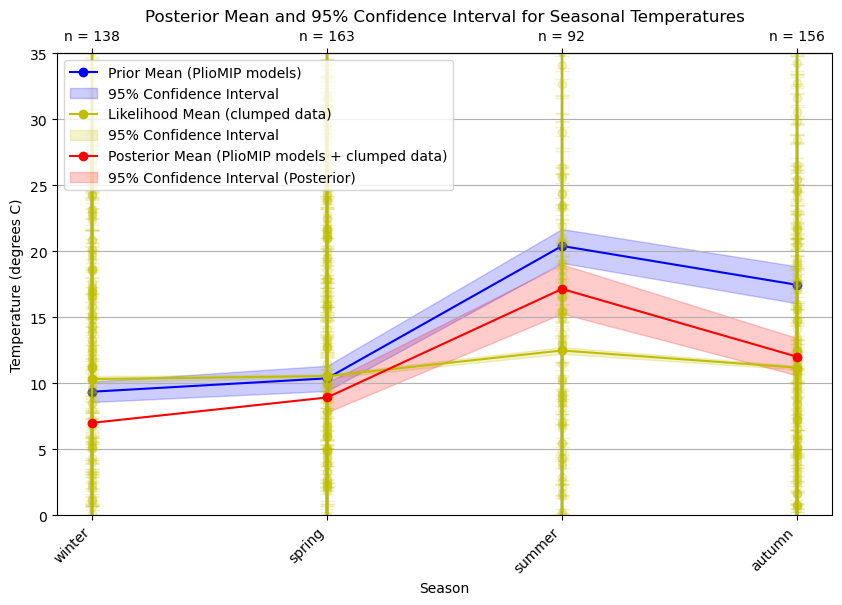

In [ ]:
# (Prior is identical to the seasonal prior above)
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[0]
cov_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC, sD47 = cov_prior_seasonalSC, return_covar = True)[0]
cov_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC, sD47 = cov_prior_seasonalSC, return_covar = True)[1]

# Plot in temperature domain
# std_prior_seasonalSC_T = np.sqrt(np.diag(cov_prior_seasonalSC_T))
std_likelihood_seasonalSC_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_T))
std_posterior_seasonalSC_T = np.sqrt(np.diag(cov_posterior_seasonalSC_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

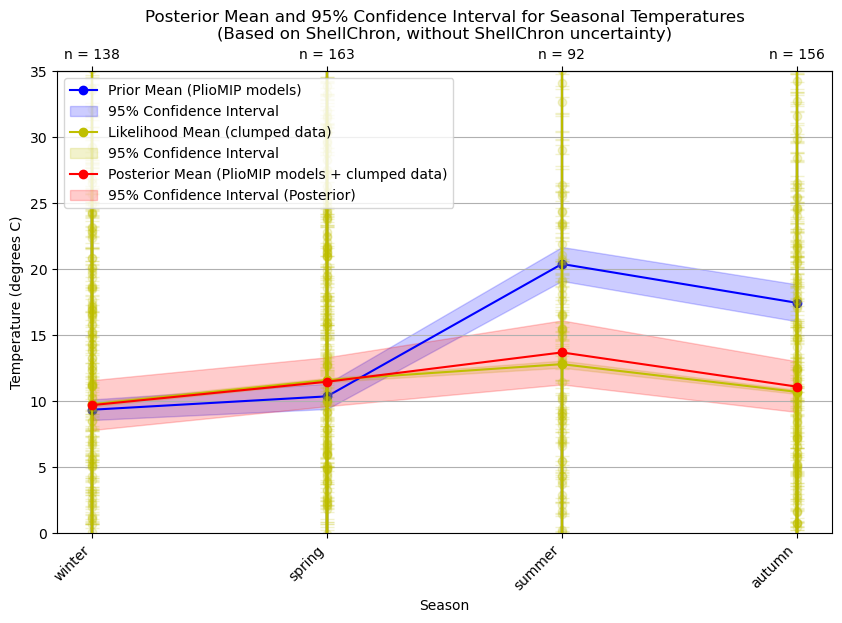

In [32]:
# (Prior is identical to the seasonal prior above)
# # Convert likelihood D47 to temp
mu_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[0]
cov_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC_noerr, sD47 = cov_prior_seasonalSC_noerr, return_covar = True)[0]
cov_posterior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC_noerr, sD47 = cov_prior_seasonalSC_noerr, return_covar = True)[1]

# Plot in temperature domain
# std_prior_seasonalSC_noerr_T = np.sqrt(np.diag(cov_prior_seasonalSC_noerr_T))
std_likelihood_seasonalSC_noerr_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))
std_posterior_seasonalSC_noerr_T = np.sqrt(np.diag(cov_posterior_seasonalSC_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonalSC_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_seasonalSC_noerr_T,
    mu_posterior_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_seasonalSC_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot including sclero-dating uncertainty

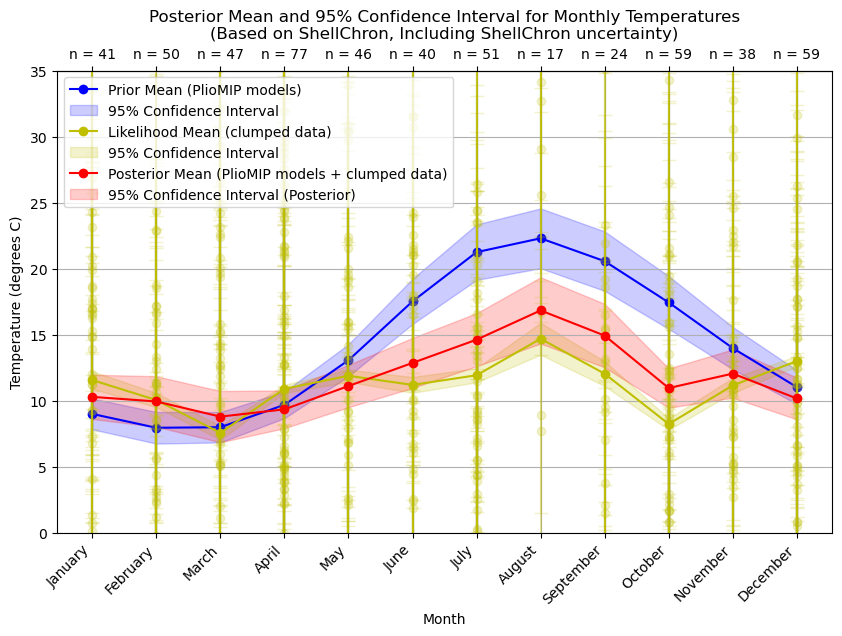

In [33]:
# Convert prior D47 to temp
mu_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[0]
cov_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[0]
cov_likelihood_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = cov_prior, return_covar = True)[0]
cov_posterior_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = cov_prior, return_covar = True)[1]

# Plot in temperature domain
std_prior_T = np.sqrt(np.diag(cov_prior_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_T))
std_posterior_T = np.sqrt(np.diag(cov_posterior_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_T - stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models),
    mu_prior_T + stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_posterior_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_posterior_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_posterior_T,
    mu_posterior_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_posterior_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot without sclero-dating uncertainty

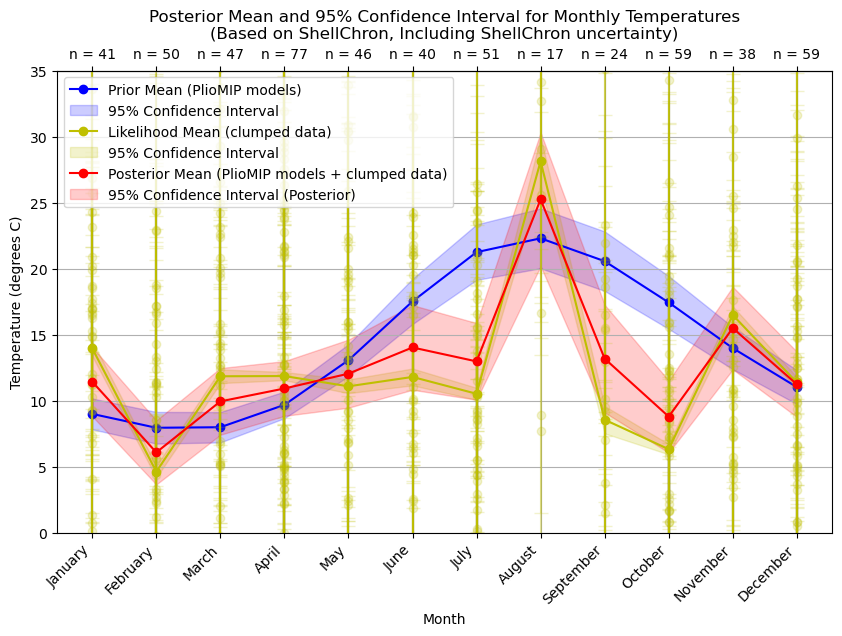

In [34]:
# (Prior is identical to the monthly prior above)
# Convert likelihood D47 to temp
mu_likelihood_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[0]
cov_likelihood_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_noerr, sD47 = cov_prior_noerr, return_covar = True)[0]
cov_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_noerr, sD47 = cov_prior_noerr, return_covar = True)[1]

# Plot in temperature domain
# std_prior_T = np.sqrt(np.diag(cov_prior_T))
std_likelihood_monthly_noerr_T = np.sqrt(np.diag(cov_likelihood_noerr_T))
std_posterior_noerr_T = np.sqrt(np.diag(cov_posterior_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_T - stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models),
    mu_prior_T + stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_posterior_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_posterior_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_posterior_noerr_T,
    mu_posterior_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_posterior_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()